## Bird Classifier

In [3]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [4]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai duckduckgo_search

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dask-cudf 21.10.1 requires cupy-cuda114, which is not installed.
ray 2.1.0 requires click<=8.0.4,>=7.0, but you have click 8.1.3 which is incompatible.
dask-cudf 21.10.1 requires dask==2021.09.1, but you have dask 2022.2.0 which is incompatible.
dask-cudf 21.10.1 requires distributed==2021.09.1, but you have distributed 2022.2.0 which is incompatible.


## Step 1: Download images of birds and non-birds

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *

In [6]:
def search_images(term, max_images=30):
    print(f'Searching for {term}')
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
urls = search_images('bird photo', 1)
urls[0]

Searching for bird photo


'https://img.fotocommunity.com/birds-from-mauritius-a5541707-4f66-488b-9a8c-786a393a659a.jpg?height=1080'

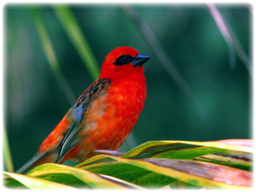

In [8]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

Searching for forest photo


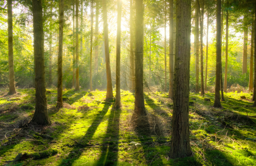

In [9]:
download_url(search_images('forest photo', 1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [10]:
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(dest, max_size=400, dest=dest)

Searching for forest photo
Searching for forest sun photo
Searching for forest shade photo
Searching for bird photo
Searching for bird sun photo
Searching for bird shade photo


## Step 2: Train our model
Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

6

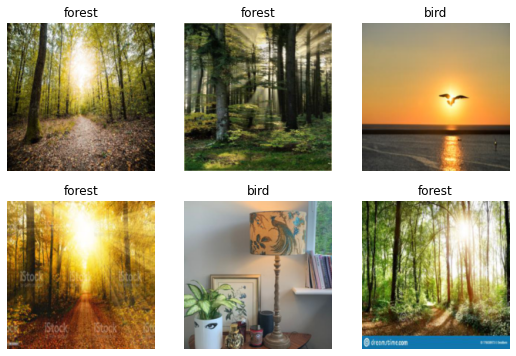

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

`get_y=parent_label`:
The labels (`y` values) is the name of the `parent` of each file (i.e. the name of the folder they're in, which will be bird or forest).


fastai comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [13]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.165116,0.279171,0.030303,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.182270,0.118253,0.030303,00:02
1,0.116736,0.042968,0.030303,00:02
2,0.077762,0.023758,0.000000,00:01


"Fine-tuning" a model means that we're starting with a model someone else has trained using some other dataset (called the pretrained model), and adjusting the weights a little bit so that the model learns to recognise your particular dataset. In this case, the pretrained model was trained to recognise photos in imagenet, and widely-used computer vision dataset with images covering 1000 categories)

## Step 3: Use the model

In [14]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))

In [15]:
print(f'This is a : {is_bird}')
print(f'Probablity it"s a bird: {probs[0]:.4f}')

This is a : bird
Probablity it"s a bird: 1.0000


Now we can export our trained `Learner`. This contains all the information needed to run the model:

In [16]:
learn.export('model.pkl')